## Libraries

In [1]:
! pip install nltk
! pip install nltk
! pip install umap-learn
! pip install plotly
! pip install transformers
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
seed=42

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from shutil import copyfile
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
import numpy as np


warnings.filterwarnings("ignore")

In [3]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Dataset

In [4]:
from google.colab import drive
import shutil

drive.mount('/content/gdrive')
#source_path = '/content/gdrive/MyDrive/pre_processed.csv'
#train_source_path = '/content/gdrive/MyDrive/StackOverflow dataset/train.csv'
#valid_source_path = '/content/gdrive/MyDrive/StackOverflow dataset/valid.csv'

#destination_path = '/content/dataset_yelp.csv'
#train_destination_path = '/content/trainStackOverflow.csv'
#valid_destination_path = '/content/validStackOverflow.csv'

#shutil.copyfile(train_source_path, train_destination_path)
#shutil.copyfile(source_path, destination_path)

Mounted at /content/gdrive


In [5]:
path = "/content/gdrive/MyDrive/dataset_text_mining/pre_processed.csv"
data = pd.read_csv(path)
#data = pd.read_csv('dataset_yelp.csv')
data.shape

(92376, 56)

In [6]:
# visualizza la distribuzione di star_x
data['stars_x'].value_counts()

,count
stars_x,
5.0,39010
4.0,24709
3.0,11076
1.0,9703
2.0,7878


In [7]:
# creation of a new column sentiment
data['sentiment'] = data['stars_x'].apply(lambda x: 'positive' if x > 3 else 'negative')
data['sentiment'].value_counts()

,count
sentiment,
positive,63719
negative,28657


In [8]:
# Sampling the dataset to be balanced and with a total of 25000 rows
positive_samples = data[data['sentiment'] == 'positive'].sample(n=15000, random_state=seed)
negative_samples = data[data['sentiment'] == 'negative'].sample(n=15000, random_state=seed)
balanced_data = pd.concat([positive_samples, negative_samples])
balanced_data.shape

(30000, 57)

In [16]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 38511 to 70736
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 30000 non-null  int64  
 1   review_id                  30000 non-null  object 
 2   user_id                    30000 non-null  object 
 3   business_id                30000 non-null  object 
 4   stars_x                    30000 non-null  float64
 5   useful                     30000 non-null  int64  
 6   funny                      30000 non-null  int64  
 7   cool                       30000 non-null  int64  
 8   text                       30000 non-null  object 
 9   date                       30000 non-null  object 
 10  name                       30000 non-null  object 
 11  address                    29877 non-null  object 
 12  city                       30000 non-null  object 
 13  state                      30000 non-null  obje

## Preprocessing

In [10]:
remove_words = ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd", 'like', 'liked', 'likes', 'love', 'loved', 'loving', 'enjoy', 'enjoyed', 'enjoying',
    'admire', 'admired', 'admiring', 'prefer', 'preferred', 'prefers', 'fantastic',
    'amazing', 'wonderful', 'excellent', 'good', 'great', 'awesome', 'best', 'perfect',
    'nice', 'beautiful', 'charming', 'delightful', 'favorite', 'pleased', 'satisfied',
    'happy', 'content', 'dislike', 'disliked', 'dislikes', 'hate', 'hated', 'hating', 'detest', 'detested',
    'detesting', 'loathe', 'loathing', 'annoyed', 'annoying', 'frustrating', 'frustrated',
    'upset', 'terrible', 'awful', 'horrible', 'worst', 'bad', 'poor', 'dissatisfied',
    'unhappy', 'displeased', 'ugly', 'disappointing', 'disappointed', 'mediocre', 'food', 'place','time', 'service', 'go', 'get', 'back', 'one', 'really', 'also', 'got']

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + remove_words
    lower_text = text.lower()
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()
    filtered_text = word_tokenize(filtered_text)                            # tokenize the whole book into words in a list.
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    return ' '.join(filtered_text)

In [11]:
dataset = pd.DataFrame()
dataset['text'] = balanced_data['text']
dataset['stars'] = balanced_data['stars_x']
dataset['sentiment'] = balanced_data['sentiment']
dataset['main_category'] = balanced_data['Main_category']
print(dataset.shape)

(30000, 3)


In [12]:
dataset['cleaned_text'] = dataset['text'].apply(lambda x: clean_text(x))

In [13]:
dataset.head()

,text,stars,sentiment,cleaned_text
38511,I went back today for a brisket sandwich. It w...,4.0,positive,go today brisket sandwich delicious texas tend...
1309,My girlfriend and I decided to give this place...,5.0,positive,girlfriend decide give try cornbeef special ho...
70198,This is my last meal in New Orleans and darn i...,4.0,positive,last meal new orleans darn mr b location dress...
77114,My kids and I just go there for fun. We don't ...,4.0,positive,kid fun purchase thing overprice many selectio...
87567,I love this place! Great pizzas and I love the...,5.0,positive,pizza halloween pumpkin pizza every halloween ...


In [23]:
dataset.head()

,text,stars,sentiment,cleaned_text,bert_cleaned,main_category
38511,I went back today for a brisket sandwich. It w...,4.0,positive,go today brisket sandwich delicious texas tend...,i went back today for a brisket sandwich it wa...,Sandwiches
1309,My girlfriend and I decided to give this place...,5.0,positive,girlfriend decide give try cornbeef special ho...,my girlfriend and i decided to give this place...,Pizza
70198,This is my last meal in New Orleans and darn i...,4.0,positive,last meal new orleans darn mr b location dress...,this is my last meal in new orleans and darn i...,Bars
77114,My kids and I just go there for fun. We don't ...,4.0,positive,kid fun purchase thing overprice many selectio...,my kids and i just go there for fun we dont pu...,Shopping
87567,I love this place! Great pizzas and I love the...,5.0,positive,pizza halloween pumpkin pizza every halloween ...,i love this place great pizzas and i love the ...,Pizza


# Representations and Embeddings

## TF-IDF


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_ngram(n_gram, df=dataset['cleaned_text']):
    vectorizer = TfidfVectorizer(ngram_range=(n_gram,n_gram))
    df_vec = vectorizer.fit_transform(df)
    return df_vec

In [ ]:
tfidf_1g_transformation= tfidf_ngram(1)
tfidf_1g_transformation.shape

(30000, 29351)

In [ ]:
# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
df_tfidf = vectorizer.fit_transform(dataset['cleaned_text'])

In [ ]:
df_tfidf.shape

K: 2, Silhouette Score: 0.0023, Inertia: 29231.8459, DBI: 14.2469
K: 3, Silhouette Score: 0.0026, Inertia: 29112.8348, DBI: 12.8792
K: 4, Silhouette Score: 0.0050, Inertia: 28984.6376, DBI: 7.4454
K: 5, Silhouette Score: 0.0050, Inertia: 28887.3017, DBI: 9.8417
K: 6, Silhouette Score: 0.0066, Inertia: 28819.2763, DBI: 8.7089
K: 7, Silhouette Score: 0.0073, Inertia: 28753.8397, DBI: 8.8814
K: 8, Silhouette Score: 0.0070, Inertia: 28651.4842, DBI: 9.2899
K: 9, Silhouette Score: 0.0076, Inertia: 28598.6252, DBI: 8.8501
K: 10, Silhouette Score: 0.0081, Inertia: 28550.1835, DBI: 9.2851
K: 11, Silhouette Score: 0.0087, Inertia: 28487.4742, DBI: 9.0898
K: 12, Silhouette Score: 0.0092, Inertia: 28439.3844, DBI: 9.0248
K: 13, Silhouette Score: 0.0099, Inertia: 28387.7595, DBI: 8.6726
K: 14, Silhouette Score: 0.0098, Inertia: 28370.5235, DBI: 8.7927
K: 15, Silhouette Score: 0.0099, Inertia: 28338.7306, DBI: 8.9149


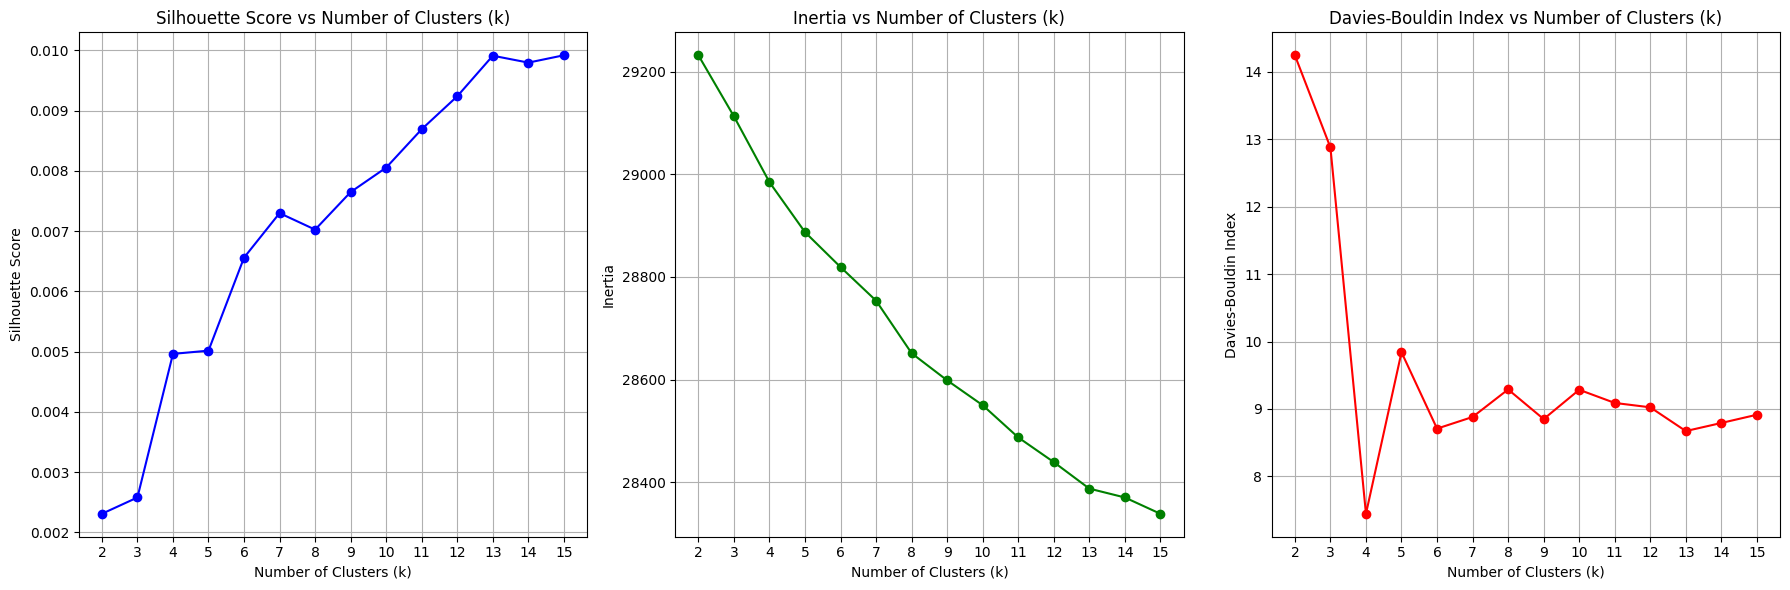

In [ ]:
# Metodo del gomito personalizzato con metriche principali
def custom_elbow_method(data, max_k=15, random_state=42):
    silhouette_scores = []
    inertia_scores = []
    dbi_scores = []
    k_values = range(2, max_k + 1)  # Silhouette e DBI non sono definiti per k=1

    # Converti la matrice sparsa in densa (se necessario)
    if hasattr(data, "toarray"):  # Verifica se è una matrice sparsa
        data = data.toarray()

    for k in k_values:
        # Clustering con KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        cluster_labels = kmeans.fit_predict(data)

        # Calcolo delle metriche
        silhouette = silhouette_score(data, cluster_labels)
        inertia = kmeans.inertia_
        dbi = davies_bouldin_score(data, cluster_labels)

        # Salva i risultati
        silhouette_scores.append(silhouette)
        inertia_scores.append(inertia)
        dbi_scores.append(dbi)

        print(f"K: {k}, Silhouette Score: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

    return k_values, silhouette_scores, inertia_scores, dbi_scores

# Esegui il metodo del gomito
k_values, silhouette_scores, inertia_scores, dbi_scores = custom_elbow_method(df_tfidf, max_k=15)

# Plot delle metriche
plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()

# Inertia
plt.subplot(1, 3, 2)
plt.plot(k_values, inertia_scores, marker='o', linestyle='-', color='g')
plt.title('Inertia vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, dbi_scores, marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Index vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()

plt.tight_layout()
plt.show()

## Doc2Vec

In [ ]:
def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english')
    lower_text = text.lower()
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()
    filtered_text = word_tokenize(filtered_text)                            # tokenizethe whole book into words in a list.
    #filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    filtered_text = [word for word in filtered_text if word not in stop_words]
    return ' '.join(filtered_text)

In [ ]:
dataset['clean_text'] = dataset['text'].apply(lambda x: clean_text(x))

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

tokenized_doc = []
for d in dataset['clean_text']:
    tokenized_doc.append(word_tokenize(d.lower()))

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data[0]

TaggedDocument(words=['went', 'back', 'today', 'brisket', 'sandwich', 'delicious', 'like', 'texas', 'good', 'tender', 'meat', 'tad', 'fatty', 'perfectly', 'fine', 'lean', 'meat', 'dry', 'flavorless', 'still', 'like', 'roll', 'careful', 'use', 'sauce', 'glad', 'went', 'back'], tags=[0])

In [ ]:
model = Doc2Vec(tagged_data, vector_size=150, min_count=1, epochs = 100)

In [ ]:
def get_doc2vec_vector(df):
    doc2vec_vectors=[]
    for sentence in df['clean_text']:
        doc2vec_vectors.append(model.infer_vector(word_tokenize(sentence.lower())))
    return doc2vec_vectors
doc2vec_vectors=get_doc2vec_vector(dataset)
len(doc2vec_vectors)

30000

K: 2, Silhouette Score: 0.0176, Inertia: 5253520.2618, DBI: 9.3582
K: 3, Silhouette Score: 0.0347, Inertia: 5215163.6658, DBI: 8.7797
K: 4, Silhouette Score: 0.0227, Inertia: 5184918.5888, DBI: 8.1249
K: 5, Silhouette Score: 0.0196, Inertia: 5184701.0976, DBI: 6.6960
K: 6, Silhouette Score: 0.0198, Inertia: 5184332.7043, DBI: 5.7020
K: 7, Silhouette Score: 0.0199, Inertia: 5183973.8911, DBI: 4.9962
K: 8, Silhouette Score: -0.0336, Inertia: 5145708.1664, DBI: 6.2228
K: 9, Silhouette Score: -0.0384, Inertia: 5128825.3600, DBI: 6.1820
K: 10, Silhouette Score: -0.0455, Inertia: 5112185.3632, DBI: 6.1870
K: 11, Silhouette Score: -0.0501, Inertia: 5101294.5231, DBI: 6.1878
K: 12, Silhouette Score: -0.0501, Inertia: 5100971.0290, DBI: 5.7380
K: 13, Silhouette Score: -0.0556, Inertia: 5088680.9501, DBI: 5.7110
K: 14, Silhouette Score: -0.0469, Inertia: 5087203.6524, DBI: 5.2377
K: 15, Silhouette Score: -0.0472, Inertia: 5086906.2180, DBI: 4.9380


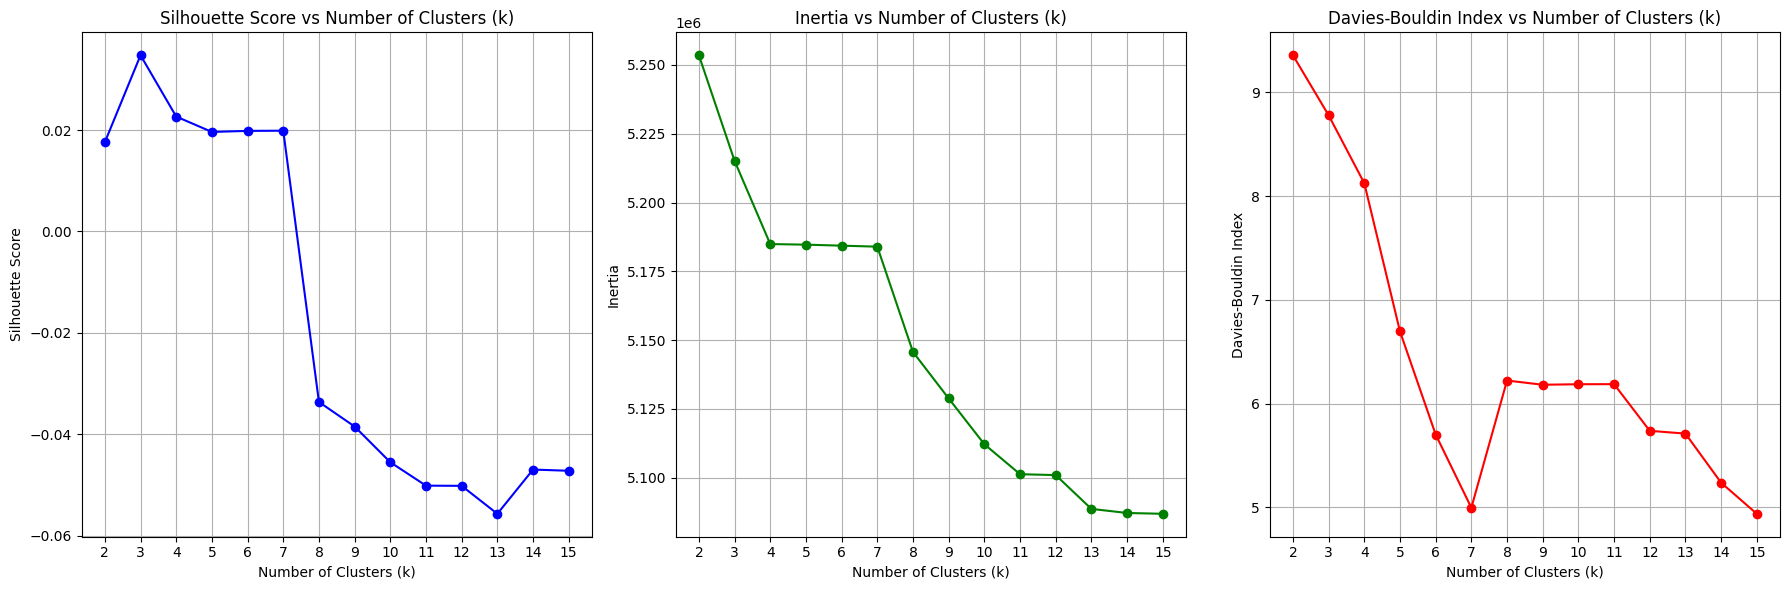

In [ ]:
# Metodo del gomito personalizzato con Doc2Vec
def custom_elbow_method_doc2vec(data, max_k=15, random_state=42):
    silhouette_scores = []
    inertia_scores = []
    dbi_scores = []
    k_values = range(2, max_k + 1)  # Silhouette e DBI non sono definiti per k=1

    for k in k_values:
        # Clustering con KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(data)
        cluster_labels = kmeans.predict(data)

        # Calcolo delle metriche
        silhouette = silhouette_score(data, cluster_labels)
        inertia = kmeans.inertia_
        dbi = davies_bouldin_score(data, cluster_labels)

        # Salva i risultati
        silhouette_scores.append(silhouette)
        inertia_scores.append(inertia)
        dbi_scores.append(dbi)

        print(f"K: {k}, Silhouette Score: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

    # Ritorna i risultati come dizionario
    return {
        "k_values": k_values,
        "silhouette_scores": silhouette_scores,
        "inertia_scores": inertia_scores,
        "dbi_scores": dbi_scores
    }

# Esegui il metodo del gomito sui vettori Doc2Vec
results_doc2vec = custom_elbow_method_doc2vec(doc2vec_vectors, max_k=15)

# Plot delle metriche
k_values = results_doc2vec["k_values"]

plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, results_doc2vec["silhouette_scores"], marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()

# Inertia
plt.subplot(1, 3, 2)
plt.plot(k_values, results_doc2vec["inertia_scores"], marker='o', linestyle='-', color='g')
plt.title('Inertia vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, results_doc2vec["dbi_scores"], marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Index vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()

plt.tight_layout()
plt.show()

# Stampa i risultati
print("Risultati del metodo del gomito personalizzato per Doc2Vec:")
for k, silhouette, inertia, dbi in zip(
    k_values, results_doc2vec["silhouette_scores"], results_doc2vec["inertia_scores"], results_doc2vec["dbi_scores"]
):
    print(f"K: {k}, Silhouette: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

## Glove


In [ ]:
import gensim.downloader as api
def get_vectors_pretrained(df, model):
    embedding_vectors = []
    for partition in df['clean_text']:
        sentence = []
        for word in partition.split(' '):
            try:
                sentence.append(model[word])
            except:
                pass

        sentence = np.array(sentence)
        if sentence.size == 0:
            sentence = np.zeros(model.vector_size)
        else:
            sentence = sentence.mean(axis=0)
        embedding_vectors.append(sentence)
        embedding_vectors.append(sentence)


    embedding_vectors = np.array(embedding_vectors)
    return embedding_vectors

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
glove_vectors=get_vectors_pretrained(dataset,glove_model)
glove_vectors

array([[ 0.06428785,  0.0580942 ,  0.11227447, ..., -0.26288119,
         0.14175335,  0.08279698],
       [ 0.06428785,  0.0580942 ,  0.11227447, ..., -0.26288119,
         0.14175335,  0.08279698],
       [ 0.01590138,  0.02030319, -0.00650716, ..., -0.2036773 ,
        -0.10320838,  0.13129833],
       ...,
       [-0.04476761,  0.11289987,  0.0168197 , ..., -0.15298153,
        -0.11130291, -0.01196533],
       [-0.17157525,  0.03996029, -0.12893823, ..., -0.11305697,
        -0.10835371, -0.02134554],
       [-0.17157525,  0.03996029, -0.12893823, ..., -0.11305697,
        -0.10835371, -0.02134554]])

K: 2, Silhouette Score: 0.1188, Inertia: 96329.2997, DBI: 2.5578
K: 3, Silhouette Score: 0.0592, Inertia: 92879.2415, DBI: 3.3831
K: 4, Silhouette Score: 0.0518, Inertia: 90802.3650, DBI: 3.5928
K: 5, Silhouette Score: 0.0469, Inertia: 89049.8040, DBI: 3.5395
K: 6, Silhouette Score: 0.0369, Inertia: 87924.2733, DBI: 3.5957
K: 7, Silhouette Score: 0.0112, Inertia: 86974.8531, DBI: 3.6962
K: 8, Silhouette Score: 0.0281, Inertia: 86170.7934, DBI: 3.8265
K: 9, Silhouette Score: 0.0106, Inertia: 85343.5805, DBI: 3.6194
K: 10, Silhouette Score: 0.0099, Inertia: 84756.1200, DBI: 3.7021
K: 11, Silhouette Score: 0.0096, Inertia: 84313.5467, DBI: 3.6255
K: 12, Silhouette Score: 0.0050, Inertia: 83730.5027, DBI: 3.7508
K: 13, Silhouette Score: 0.0089, Inertia: 83254.8357, DBI: 3.5470
K: 14, Silhouette Score: 0.0061, Inertia: 82802.6008, DBI: 3.5816
K: 15, Silhouette Score: 0.0093, Inertia: 82363.2668, DBI: 3.5232


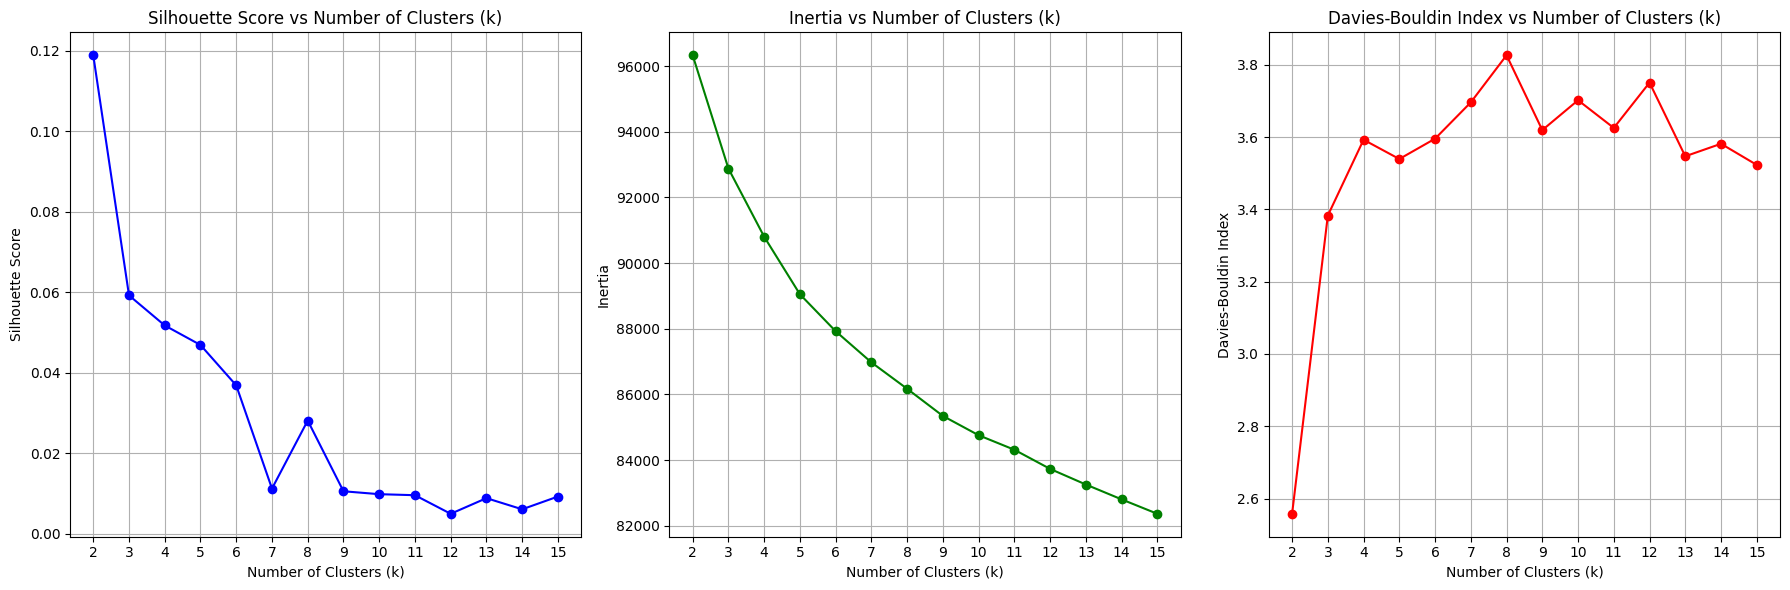

Risultati del metodo del gomito personalizzato per GloVe:
K: 2, Silhouette: 0.1188, Inertia: 96329.2997, DBI: 2.5578
K: 3, Silhouette: 0.0592, Inertia: 92879.2415, DBI: 3.3831
K: 4, Silhouette: 0.0518, Inertia: 90802.3650, DBI: 3.5928
K: 5, Silhouette: 0.0469, Inertia: 89049.8040, DBI: 3.5395
K: 6, Silhouette: 0.0369, Inertia: 87924.2733, DBI: 3.5957
K: 7, Silhouette: 0.0112, Inertia: 86974.8531, DBI: 3.6962
K: 8, Silhouette: 0.0281, Inertia: 86170.7934, DBI: 3.8265
K: 9, Silhouette: 0.0106, Inertia: 85343.5805, DBI: 3.6194
K: 10, Silhouette: 0.0099, Inertia: 84756.1200, DBI: 3.7021
K: 11, Silhouette: 0.0096, Inertia: 84313.5467, DBI: 3.6255
K: 12, Silhouette: 0.0050, Inertia: 83730.5027, DBI: 3.7508
K: 13, Silhouette: 0.0089, Inertia: 83254.8357, DBI: 3.5470
K: 14, Silhouette: 0.0061, Inertia: 82802.6008, DBI: 3.5816
K: 15, Silhouette: 0.0093, Inertia: 82363.2668, DBI: 3.5232


In [ ]:
# Metodo del gomito personalizzato con GloVe
def custom_elbow_method_glove(data, max_k=15, random_state=42):
    silhouette_scores = []
    inertia_scores = []
    dbi_scores = []
    k_values = range(2, max_k + 1)  # Silhouette e DBI non sono definiti per k=1

    for k in k_values:
        # Clustering con KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        cluster_labels = kmeans.fit_predict(data)

        # Calcolo delle metriche
        silhouette = silhouette_score(data, cluster_labels)
        inertia = kmeans.inertia_
        dbi = davies_bouldin_score(data, cluster_labels)

        # Salva i risultati
        silhouette_scores.append(silhouette)
        inertia_scores.append(inertia)
        dbi_scores.append(dbi)

        print(f"K: {k}, Silhouette Score: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

    # Ritorna i risultati come dizionario
    return {
        "k_values": k_values,
        "silhouette_scores": silhouette_scores,
        "inertia_scores": inertia_scores,
        "dbi_scores": dbi_scores
    }

# Esegui il metodo del gomito sui vettori GloVe
results_glove = custom_elbow_method_glove(glove_vectors, max_k=15)

# Plot delle metriche
k_values = results_glove["k_values"]

plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, results_glove["silhouette_scores"], marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()

# Inertia
plt.subplot(1, 3, 2)
plt.plot(k_values, results_glove["inertia_scores"], marker='o', linestyle='-', color='g')
plt.title('Inertia vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, results_glove["dbi_scores"], marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Index vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()

plt.tight_layout()
plt.show()

# Stampa i risultati
print("Risultati del metodo del gomito personalizzato per GloVe:")
for k, silhouette, inertia, dbi in zip(
    k_values, results_glove["silhouette_scores"], results_glove["inertia_scores"], results_glove["dbi_scores"]
):
    print(f"K: {k}, Silhouette: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

## Sentence Trasformer - BERT fine-tuned

In [24]:
def soft_text_normalization(text):
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\d+', '', text)
  text = text.lower()
  return text

dataset['bert_cleaned'] = dataset['text'].apply(soft_text_normalization)
docs = dataset['bert_cleaned'].tolist()
len(docs)

30000

In [ ]:
# Creating bert embeddings using a fine tuned model
model = SentenceTransformer('/content/gdrive/MyDrive/dataset_text_mining/fine_tuned_model1')
embeddings_bert = model.encode(docs)

K: 2, Silhouette Score: 0.8505, Inertia: 3942.0911, DBI: 0.2501
K: 3, Silhouette Score: 0.9066, Inertia: 1123.9208, DBI: 0.3478
K: 4, Silhouette Score: 0.9351, Inertia: 399.8870, DBI: 0.1229
K: 5, Silhouette Score: 0.9372, Inertia: 250.9741, DBI: 0.3873
K: 6, Silhouette Score: 0.9147, Inertia: 185.9223, DBI: 0.4195
K: 7, Silhouette Score: 0.9101, Inertia: 146.4225, DBI: 0.4568
K: 8, Silhouette Score: 0.8869, Inertia: 119.9704, DBI: 0.5022
K: 9, Silhouette Score: 0.8763, Inertia: 106.0229, DBI: 0.5375
K: 10, Silhouette Score: 0.8628, Inertia: 100.7258, DBI: 0.5922
K: 11, Silhouette Score: 0.8371, Inertia: 84.7241, DBI: 0.6139
K: 12, Silhouette Score: 0.8208, Inertia: 75.6537, DBI: 0.6480
K: 13, Silhouette Score: 0.8006, Inertia: 69.7675, DBI: 0.6761
K: 14, Silhouette Score: 0.7814, Inertia: 65.4390, DBI: 0.7091
K: 15, Silhouette Score: 0.7816, Inertia: 61.4731, DBI: 0.7123


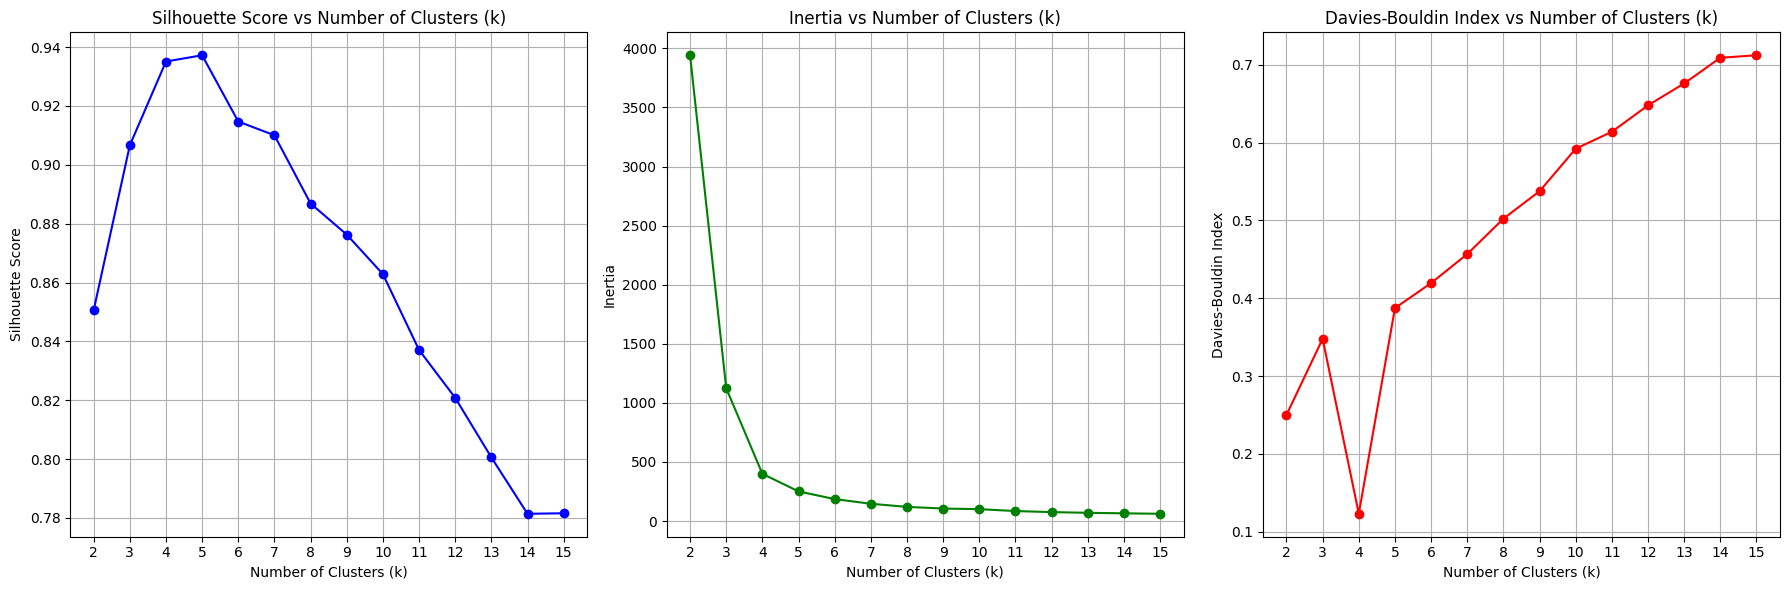

Risultati del metodo del gomito personalizzato per BERT fine tuned:
K: 2, Silhouette: 0.8505, Inertia: 3942.0911, DBI: 0.2501
K: 3, Silhouette: 0.9066, Inertia: 1123.9208, DBI: 0.3478
K: 4, Silhouette: 0.9351, Inertia: 399.8870, DBI: 0.1229
K: 5, Silhouette: 0.9372, Inertia: 250.9741, DBI: 0.3873
K: 6, Silhouette: 0.9147, Inertia: 185.9223, DBI: 0.4195
K: 7, Silhouette: 0.9101, Inertia: 146.4225, DBI: 0.4568
K: 8, Silhouette: 0.8869, Inertia: 119.9704, DBI: 0.5022
K: 9, Silhouette: 0.8763, Inertia: 106.0229, DBI: 0.5375
K: 10, Silhouette: 0.8628, Inertia: 100.7258, DBI: 0.5922
K: 11, Silhouette: 0.8371, Inertia: 84.7241, DBI: 0.6139
K: 12, Silhouette: 0.8208, Inertia: 75.6537, DBI: 0.6480
K: 13, Silhouette: 0.8006, Inertia: 69.7675, DBI: 0.6761
K: 14, Silhouette: 0.7814, Inertia: 65.4390, DBI: 0.7091
K: 15, Silhouette: 0.7816, Inertia: 61.4731, DBI: 0.7123


In [ ]:
# Metodo del gomito personalizzato con BERT fine tuned
def custom_elbow_method_bert(data, max_k=15, random_state=42):
    silhouette_scores = []
    inertia_scores = []
    dbi_scores = []
    k_values = range(2, max_k + 1)  # Silhouette e DBI non sono definiti per k=1

    for k in k_values:
        # Clustering con KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        cluster_labels = kmeans.fit_predict(data)

        # Calcolo delle metriche
        silhouette = silhouette_score(data, cluster_labels)
        inertia = kmeans.inertia_
        dbi = davies_bouldin_score(data, cluster_labels)

        # Salva i risultati
        silhouette_scores.append(silhouette)
        inertia_scores.append(inertia)
        dbi_scores.append(dbi)

        print(f"K: {k}, Silhouette Score: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

    # Ritorna i risultati come dizionario
    return {
        "k_values": k_values,
        "silhouette_scores": silhouette_scores,
        "inertia_scores": inertia_scores,
        "dbi_scores": dbi_scores
    }

# Esegui il metodo del gomito sui vettori BERT
results_bert = custom_elbow_method_bert(embeddings_bert, max_k=15)

# Plot delle metriche
k_values = results_bert["k_values"]

plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_values, results_bert["silhouette_scores"], marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()

# Inertia
plt.subplot(1, 3, 2)
plt.plot(k_values, results_bert["inertia_scores"], marker='o', linestyle='-', color='g')
plt.title('Inertia vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, results_bert["dbi_scores"], marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Index vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()

plt.tight_layout()
plt.show()

# Stampa i risultati
print("Risultati del metodo del gomito personalizzato per BERT fine tuned:")
for k, silhouette, inertia, dbi in zip(
    k_values, results_bert["silhouette_scores"], results_bert["inertia_scores"], results_bert["dbi_scores"]
):
    print(f"K: {k}, Silhouette: {silhouette:.4f}, Inertia: {inertia:.4f}, DBI: {dbi:.4f}")

## Embedding dictionary

In [ ]:
text_embedding={
    'TF_IDF':df_tfidf.toarray(),
    'Doc2vec':np.array(doc2vec_vectors),
    'Glove':glove_vectors,
    'BERT':embeddings_bert
}

In [ ]:
import pickle
a_file = open("EmbeddingText_edited.pkl", "wb")
pickle.dump(text_embedding, a_file)
a_file.close()
print('Saved')

Saved


# Clustering (further investigations)

In [27]:
# Set the seaborn style
import seaborn as sns
sns.set_theme()

In [28]:
# seleziona in embedding i risultati di docwvec
embedding_best=embeddings_bert #text_embedding['BERT']
embedding_best.shape

(30000, 384)

In [72]:
from sklearn import metrics
# Confusion matrix
def confusion_matrix(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    sns.heatmap(contingency_matrix, annot=True, fmt='d', cmap='Blues')
    # Calcola le posizioni dei tick centrati
    y_ticks_positions = np.arange(0.5, len(np.unique(y_true)), 1)
    x_ticks_positions = np.arange(0.5, len(np.unique(y_pred)), 1)

    # Imposta i tick centrati sulle righe (y) e sulle colonne (x)
    plt.yticks(y_ticks_positions, np.unique(y_true), rotation= 45)
    plt.xticks(x_ticks_positions, np.unique(y_pred))

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [73]:
# Purity score
def purity(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## k = 5

In [29]:
# Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
cluster_labels = kmeans.fit_predict(embedding_best)

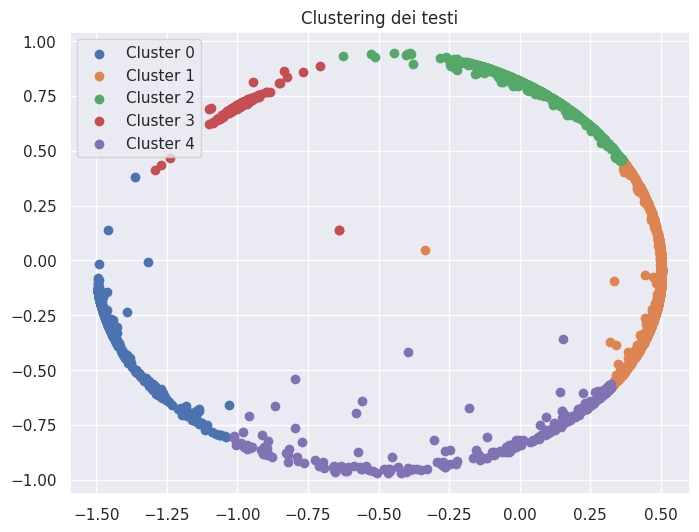

In [30]:
# Visualizzazione (riduzione dimensionale con PCA)
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_best)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(embedding_2d[cluster_labels == i, 0], embedding_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title("Clustering dei testi")
plt.show()

### Evaluation

#### Internal index

In [31]:
# Evaluate the silhouette
print("Silhouette score:", silhouette_score(embedding_best, cluster_labels))

Silhouette score: 0.9372427


#### External indexes

In [32]:
# Evaluate the rand index on the stars
from sklearn.metrics import rand_score
rand_index = rand_score(dataset['stars'], cluster_labels)
print("Rand index:", rand_index)

Rand index: 0.49855849639432426


In [64]:
# Evaluate the purity over the stars
purity_score = purity(dataset['stars'], cluster_labels)
print("Purity score:", purity_score)

Purity score: 0.3046333333333333


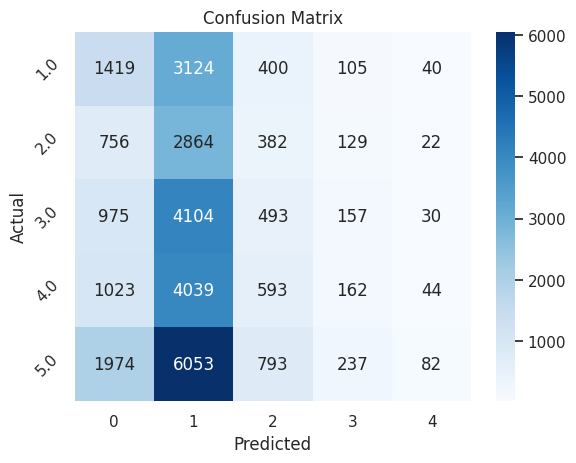

In [60]:
# confusion matrix over the stars
confusion_matrix(dataset['stars'], cluster_labels)

## K = 19


In [69]:
# Clustering
n_clusters = 19
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
cluster_labels = kmeans.fit_predict(embedding_best)

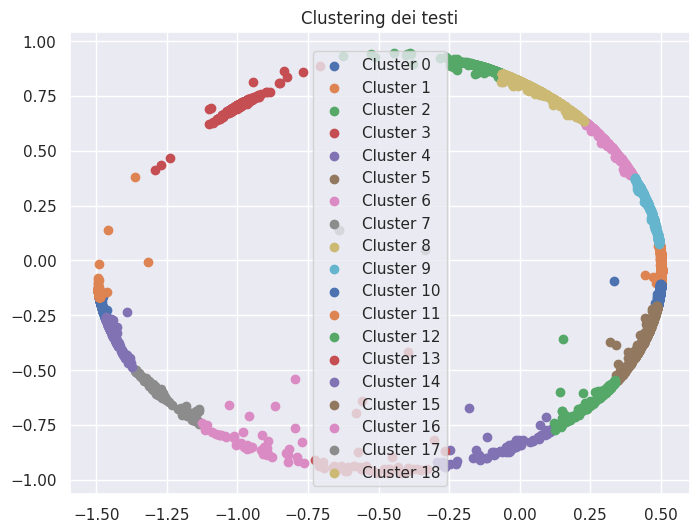

In [70]:
# Visualizzazione (riduzione dimensionale con PCA)
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_best)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(embedding_2d[cluster_labels == i, 0], embedding_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title("Clustering dei testi")
plt.show()

### Evaluation

#### Internal index

In [71]:
# Evaluate the silhouette
print("Silhouette score:", silhouette_score(embedding_best, cluster_labels))

Silhouette score: 0.68235403


#### External index

In [76]:
# Evaluate the rand index on the main category
rand_index = rand_score(dataset['main_category'], cluster_labels)
print("Rand index:", rand_index)

Rand index: 0.6068680244897052


In [77]:
# Evaluate the purity over the main categories
purity_score = purity(dataset['main_category'], cluster_labels)
print("Purity score:", purity_score)

Purity score: 0.2586333333333333


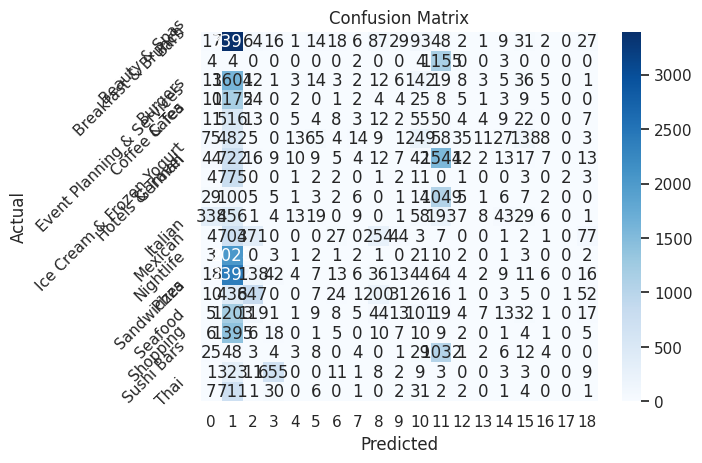

In [78]:
# confusion matrix over the categories
confusion_matrix(dataset['main_category'], cluster_labels)